# Imports

In [1]:
#### Import Section
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from wrangle import prep, acquire_zillow

from itertools import product
from scipy.stats import pearsonr, spearmanr, mannwhitneyu, f_oneway
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE, f_regression, SelectKBest

import warnings
warnings.filterwarnings("ignore")



Number of observations removed: 5898


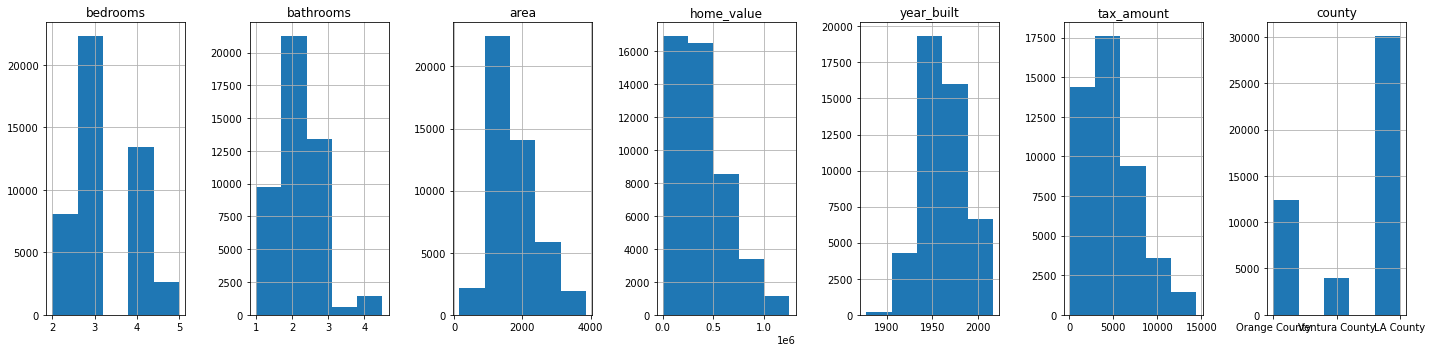

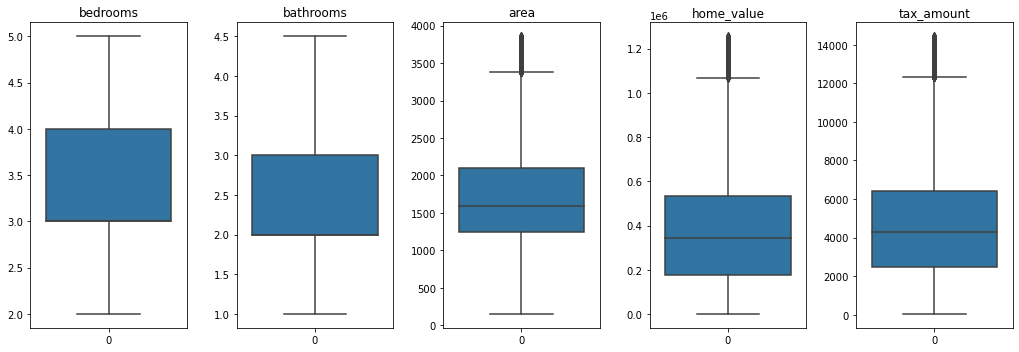

In [2]:
df, train, train_scaled, validate, validate_scaled, test, test_scaled = prep(acquire_zillow())

# Explore 

## Bivariate - Pairplots 
* Examine variables in relationship to each other

In [3]:
def plot_variable_pairs (df):
    """ 
    Purpose
        Plot pairwise relationships of zillow dataframe
        Ignores Categorical columns
    
    Parameters
        df: a dataframe containing zillow real estate data

    Returns
        None
    """

    #initialize a seaborn pairgrid
    g = sns.PairGrid(df.drop(columns=['year_built', 'county']), diag_sharey=True, corner=True)
    
    #fills out the pairgrid with a regplot
    g.map_lower(sns.regplot, line_kws={'color':'r'})
    return 

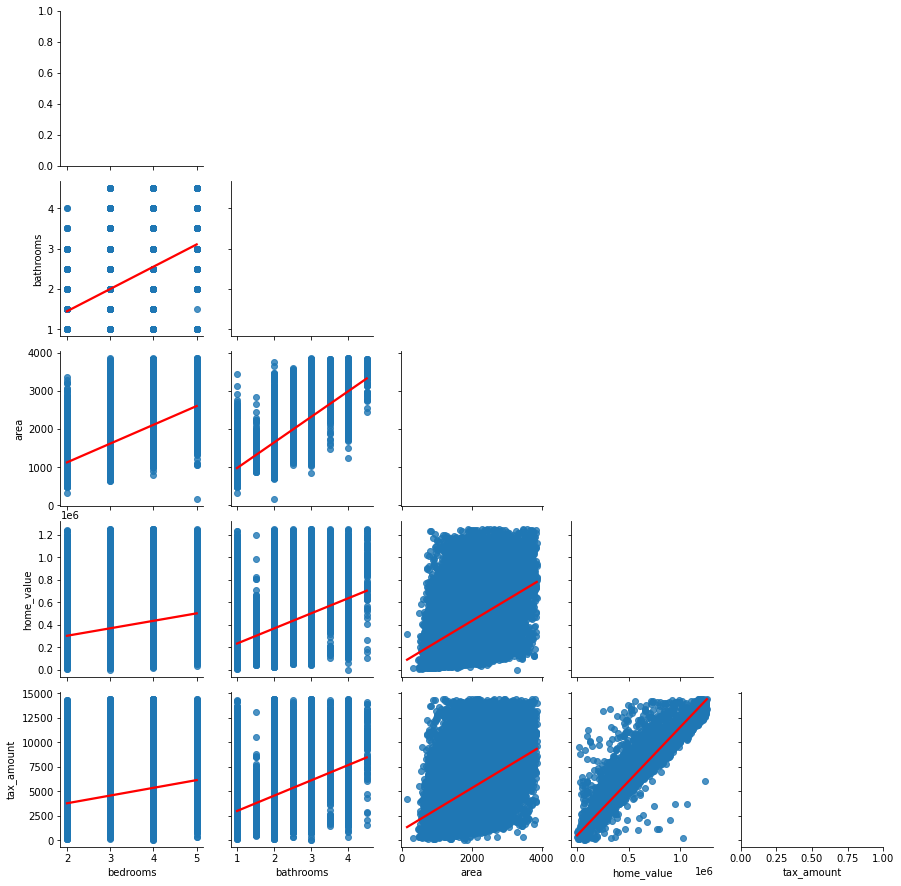

In [4]:
plot_variable_pairs(train)

### Takeaways
* Home_value and tax_amount highly correlated
    - How much correlation? Enough to remove? Worth examining ratio?
* Area high correlation with bedrooms and bathrooms
    - How much correlation? 
* home_value more correlated with bathrooms than bedrooms

In [5]:
def plot_cat_var_pairs(df):
    """ 
    Purpose
        Plot pairwise relationships of zillow dataframe utlizing sample size 1000
        Ignores Categorical columns

    Parameters
        df: a dataframe containing zillow real estate data

    Returns
    None
    """

    categorical_col = ['year_built', 'county']

    continuous_col = df.drop(columns=['year_built', 'county']).columns

    g = sns.PairGrid(data=df, 
                y_vars=continuous_col,
                x_vars=categorical_col, 
                height=4, 
                aspect=2)
    g.map(sns.swarmplot)
    g.axes[0,0].set_xticks(np.arange(0,104,20));

    g = sns.PairGrid(data=df, 
                y_vars=continuous_col,
                x_vars='county', 
                height=4, 
                aspect=2)
    g.map(sns.boxplot);

    g = sns.PairGrid(data=df, 
                y_vars=continuous_col,
                x_vars='year_built', 
                height=4, 
                aspect=2)

    g.map(sns.barplot)
    g.axes[0,0].set_xticks(np.arange(0,104,20));
    
    return

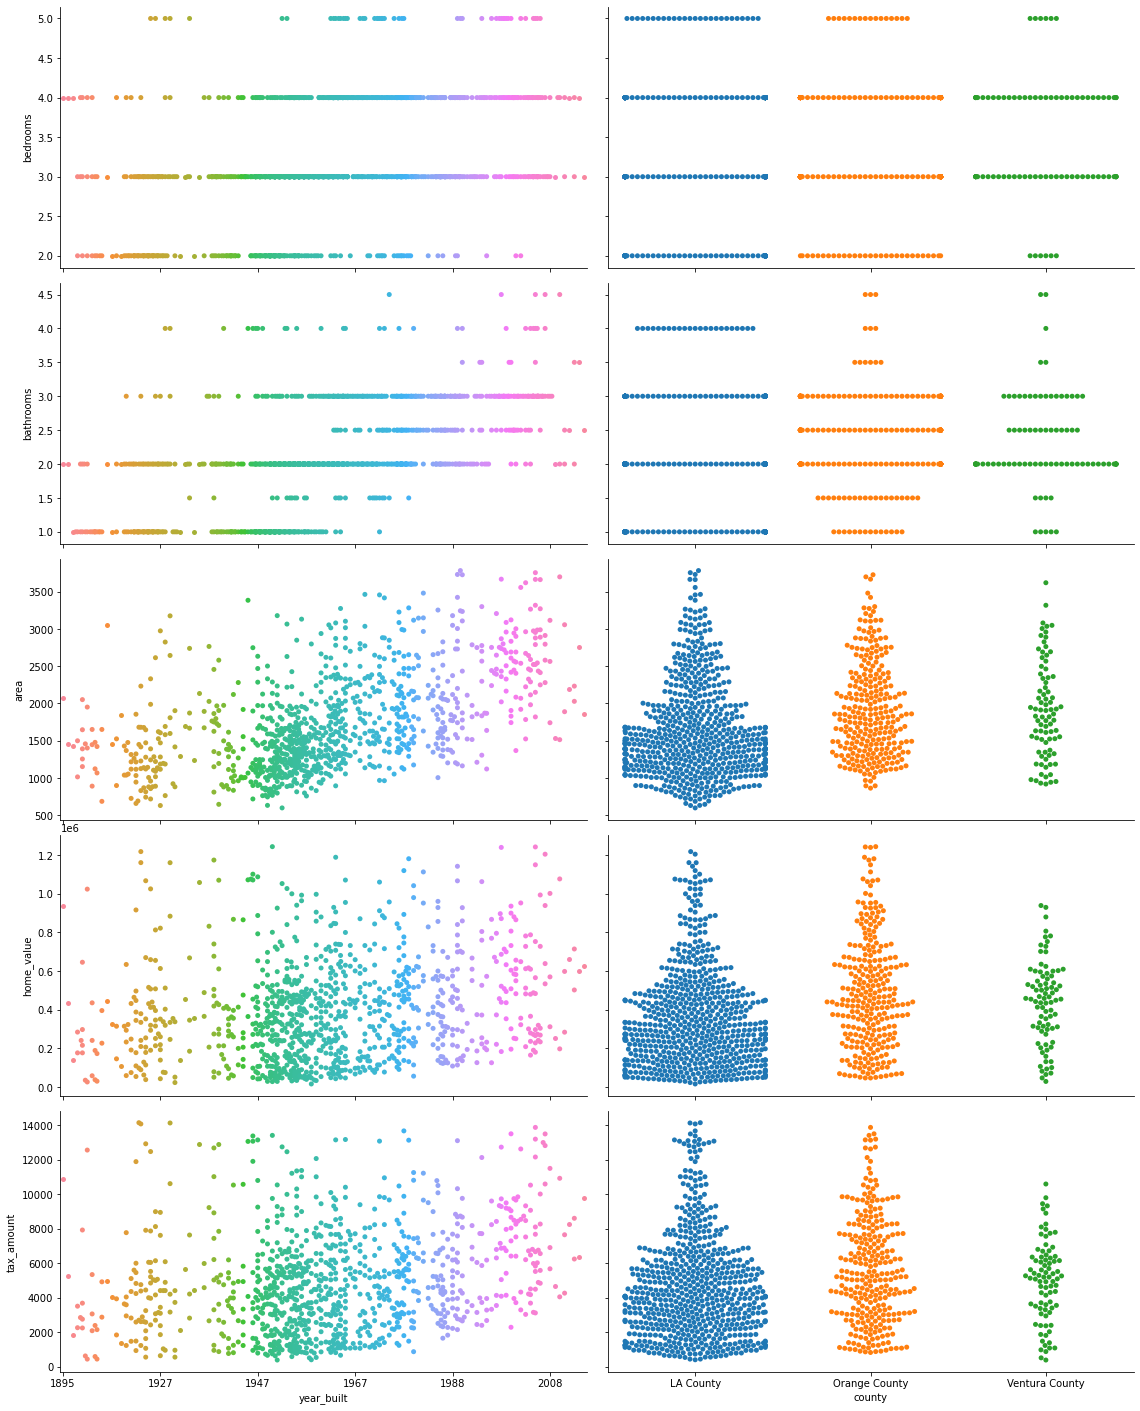

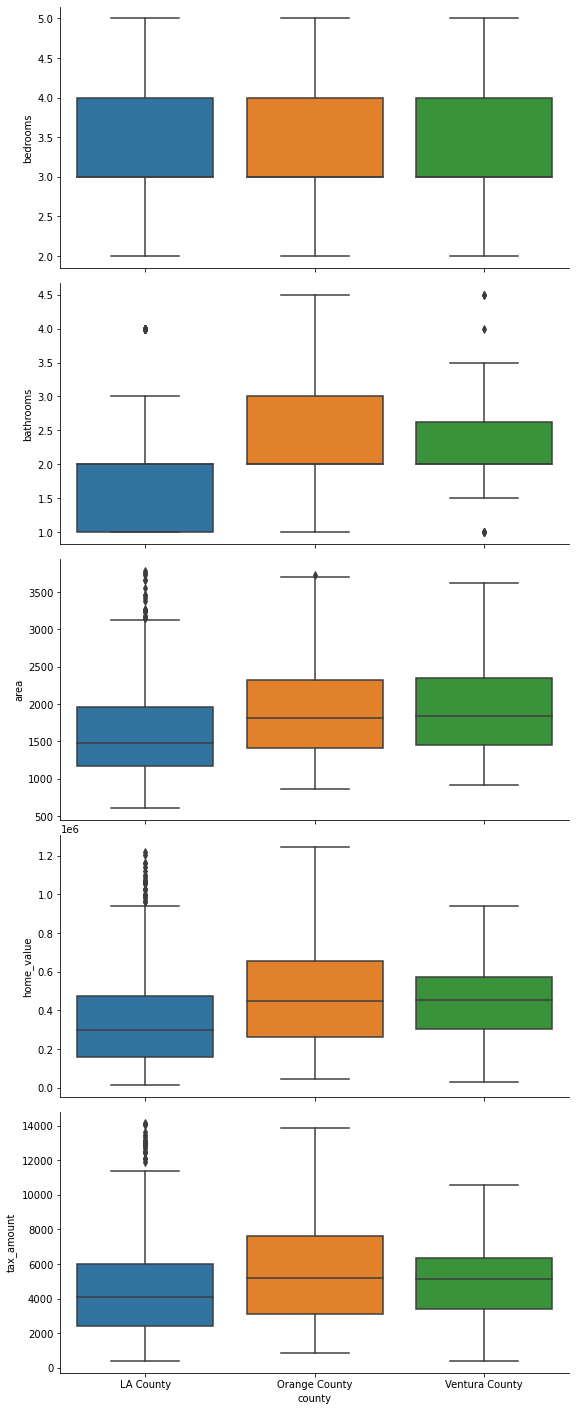

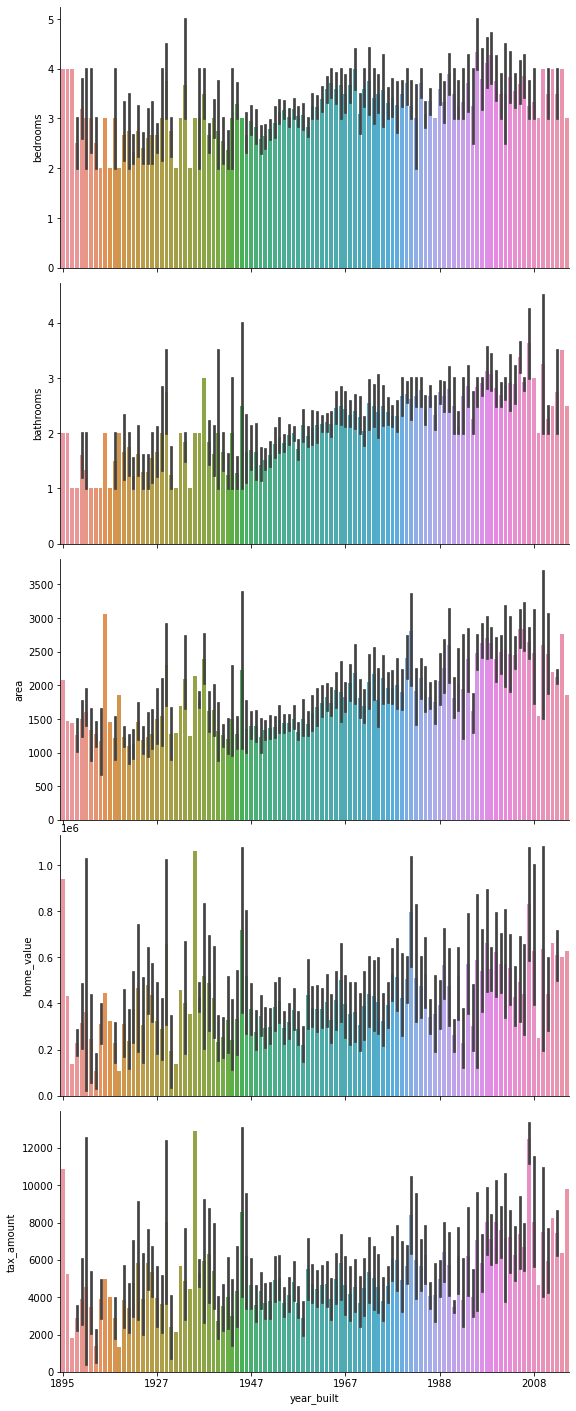

In [6]:
plot_cat_var_pairs(train.sample(n=1000))

### Takeaways
> years_built
- less modern (1985) homes < 3 bedrooms, and less than < 2 bathrooms
- average area of new homes may have risen in past 30 years --> investigate
- tax amount climbing faster than tax value

> County
- LA County bottom heavy in tax_value/tax_amount, as well as largest category 
- Ventura and Orange bedrooms/bathrooms comparable
- Orange County highest mean area


### Home Value vs Everything

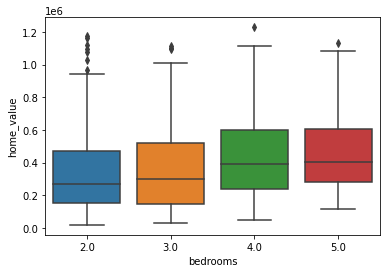

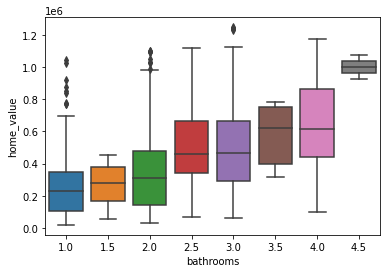

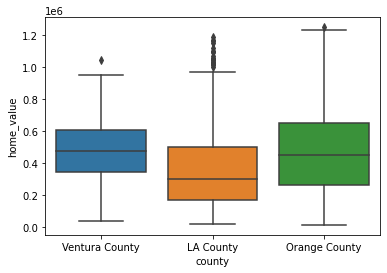

In [7]:
for col in ['bedrooms', 'bathrooms', 'county']:
    sns.boxplot(data=train.sample(n=1000), y='home_value', x=col)
    plt.show()


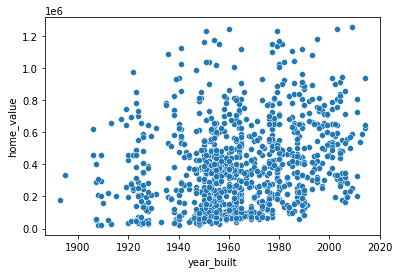

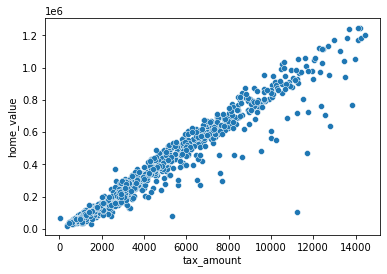

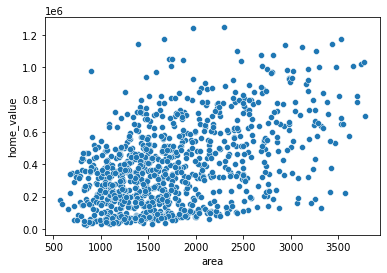

In [8]:
for col in ['year_built', 'tax_amount', 'area']:
    sns.scatterplot(data=train.sample(n=1000), y='home_value', x=col)
    plt.show()

### Takeaways
* huge jump for value when going above 3 bathrooms
* No other major new takeaways

## Multivariate

### Home Value Vs Area Vs The Rest

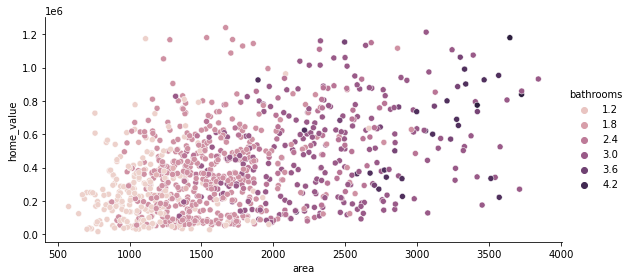

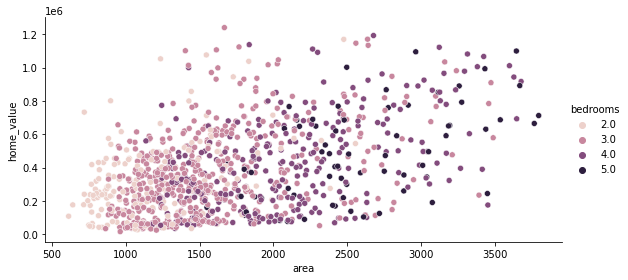

In [9]:
for col in train[['bathrooms', 'bedrooms']].columns:

    sns.relplot(data=train.sample(n=1000), x='area', y='home_value',
                hue=col, height=4, aspect=2)
    plt.show()

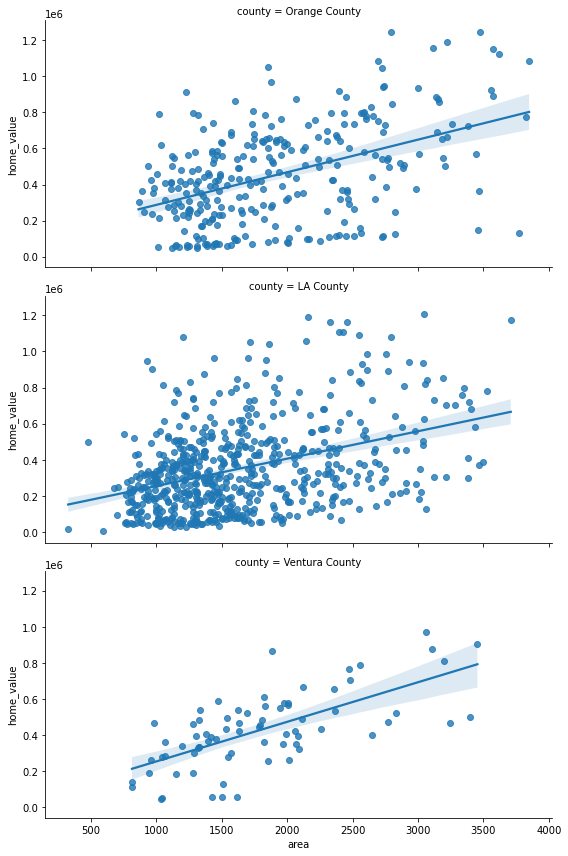

In [10]:
sns.lmplot(data=train.sample(n=1000), x='area', y='home_value', row='county', height=4, aspect=2)

### Takeaways
* not very large discrepencies between the counties based on bathrooms or bedrooms.
* nothing very interesting here 

### Home Value Vs Year_Built Vs The Rest

In [11]:
#had to create column to enable use of certain plots
train['num_year_built'] = train.year_built.astype('int')

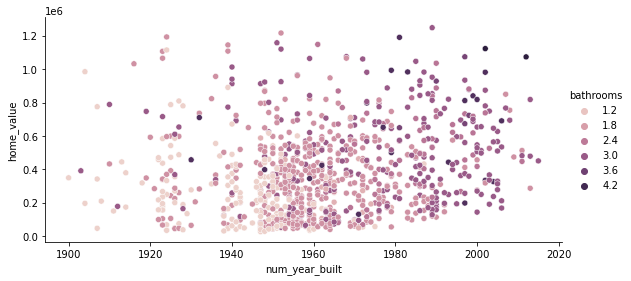

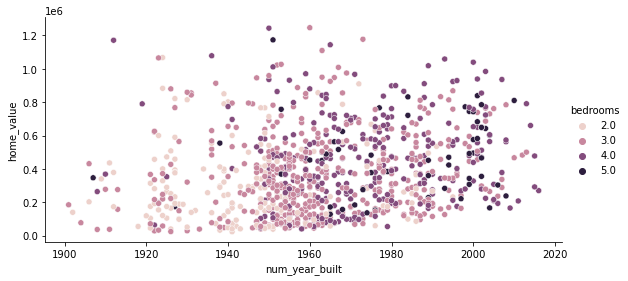

In [12]:
for col in train[['bathrooms', 'bedrooms']].columns:

    sns.relplot(data=train.sample(n=1000), x='num_year_built', y='home_value',
                hue=col, height=4, aspect=2)
    plt.show()

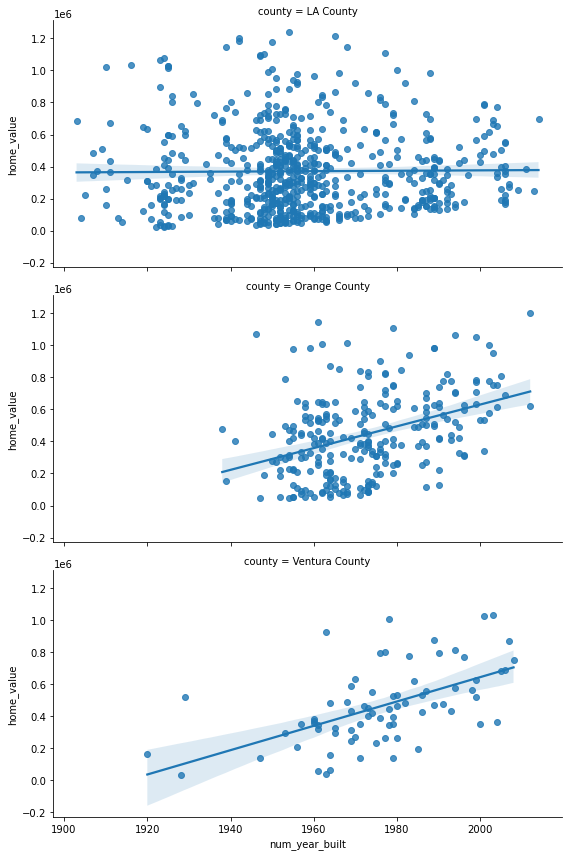

In [13]:
sns.lmplot(data=train.sample(n=1000), x='num_year_built', y='home_value', row='county', height=4, aspect=2)

## Takeaways
* Newer Homes in LA County not seeing the same rise in value

## Specific Questions with plots and tests

### Question - Is there difference in median home value between counties?
${H_0}$: There is no significant difference in median home value between counties  
${H_a}$: There is significant difference in median home value between counties  
${\alpha}$: .05

> Result: There is enough evidence to reject our null hypothesis. **Test code below**

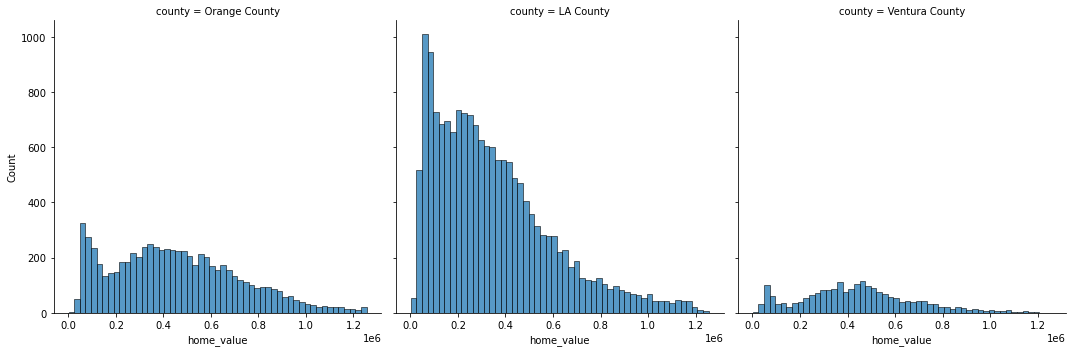

In [14]:
#visualization first
sns.displot(data=train, x='home_value', col='county', kind='hist');

In [15]:
#fips 6059 has highest mean value --> for variances what is the threshold for useability?
la_county = train[train.county == 'LA County'].home_value
orange_county = train[train.county == 'Orange County'].home_value
ventura_county = train[train.county == 'Ventura County'].home_value

alpha = .05
f, p = f_oneway(la_county, orange_county, ventura_county)

print (f'ANOVA test statistic value: {f}')
print (f'p-value : {p}')

if p > alpha:
    print(f'Fail to reject the null hypothesis, because our p-value is greater than our alpha.')
else: 
    print(f'There is enough evidence to reject our null hypothesis')

ANOVA test statistic value: 497.49086643226065
p-value : 9.452428719808004e-213
There is enough evidence to reject our null hypothesis


### Question -  Why do some properties have a much higher value than others when they are located so close to each other? 

### Question -  Why are some properties valued so differently from others when they have nearly the same physical attributes but only differ in location?

### Question - Is having 1 bathroom worse than having 2 bedrooms?

# Model
Using scaled dataset

In [16]:
# create X,y for train, validate and test subsets
X_train = train_scaled.drop(columns='home_value')
y_train = train_scaled.home_value
X_val = validate_scaled.drop(columns='home_value')
y_val = validate_scaled.home_value
X_test = test_scaled.drop(columns='home_value')
y_test = test_scaled.home_value

In [17]:
#shift y subsets into a data frame
y_train = pd.DataFrame(y_train)
y_val = pd.DataFrame(y_val)
y_test = pd.DataFrame(y_test)

In [18]:
#get dummies for X subsets
X_train = pd.get_dummies(X_train, columns=['county'], drop_first=True)
X_val = pd.get_dummies(X_val, columns=['county'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['county'], drop_first=True)

In [19]:
#set up for features
#all_features = list(X_train.columns)

req_features  = ['area', 'bedrooms', 'bathrooms']

feat_combos = [req_features]

In [20]:
#baseline --> choose median because data is scaled

#add baseline columns
y_train['pred_median'] = y_train.home_value.median()
y_val['pred_median'] = y_val.home_value.median()

#add/calc RMSEs for median baseline predictions
rmse_train = mean_squared_error(y_train.home_value, y_train.pred_median, squared=False)
rmse_val = mean_squared_error(y_val.home_value, y_val.pred_median, squared=False)

print(f'RMSEs: Median\n Train/In Sample: {round(rmse_train, 2)}\n Validate/Out of Sample: {round(rmse_val, 2)}')



RMSEs: Median
 Train/In Sample: 0.21
 Validate/Out of Sample: 0.21


#PF

In [77]:
def pf_mod(X, y, selectors, fit_train=None, fit_y_train=None):

    for idx, combo in enumerate(selectors):
        pf = PolynomialFeatures(degree=combo[1])

        lm = LinearRegression(normalize=True)

        if fit_train is not None:
            fit_pf = pf.fit_transform(fit_train[combo[0]])
            X_pf = pf.transform(X[combo[0]])  
            lm.fit(fit_pf, fit_y_train.home_value)
        else:
            X_pf = pf.fit_transform(X[combo[0]])
            lm.fit(X_pf, y.home_value)

        model_label = f'Polynomial_{idx+1}'

        #fit model 
    

        #predict train
        y[model_label] = lm.predict(X_pf) 

        #calculate train rmse
        rmse = mean_squared_error(y.home_value, y[model_label], squared=False)

        print(f'{model_label} with degree: {combo[1]} \n\
            Features: {combo[0]} \n\
            RMSE: {rmse}\n')

    return

In [45]:
#create a list of selectors to cycle through model parameters, and 
pf_parameters = [2,3]

selectors = list(product(feat_combos, pf_parameters))

#call pf function to get predictions for the Polynomial models and add to the dataframe
pf_mod(X_train, y_train, selectors)

Polynomial_1 with degree: 2 
            Features: ['area', 'bedrooms', 'bathrooms'] 
            RMSE: 0.17968934568368386

Polynomial_2 with degree: 3 
            Features: ['area', 'bedrooms', 'bathrooms'] 
            RMSE: 0.1795673804742697



In [23]:
def ols_mod(X, y, selectors, fit_x_train=None, fit_y_train=None):

    for idx, features in enumerate(selectors):  
        lm = LinearRegression()
    
        model_label = f'OLS_{idx+1}'

        if fit_x_train is not None:
            lm.fit(fit_x_train[features], fit_y_train.home_value)
        else:   
            lm.fit(X[features], y.home_value)

        #predict train
        y[model_label] = lm.predict(X[features]) 

        #calc trian rmse
        rmse_train = mean_squared_error(y.home_value, y[model_label], squared=False)

        print(f'{model_label} with LinearRegression\n\
            Features: {features}\n\
            RMSE: {rmse_train}\n')

    return

In [24]:
#run ols model with feature combinations
ols_mod(X_train, y_train, feat_combos)

RMSE for OLS_1 with LinearRegression
            Features: ['area', 'bedrooms', 'bathrooms']
            Training/In-Sample: 0.17987783689320827



In [25]:
def lars_mod(X, y, selectors):

    for idx, combo in enumerate(selectors):  
        lars = LassoLars(alpha=combo[0])
    
        model_label = f'LARS_{idx+1}'

        #fit mode 
        lars.fit(X, y.home_value)

        #predict train
        y[model_label] = lars.predict(X) 

        #calc trian rmse
        rmse_train = mean_squared_error(y.home_value, y[model_label], squared=False)

        print(f'RMSE for {model_label} with Alpha: {combo[0]}\n\
            Features:{combo[1]}\n\
            Training/In-Sample: {rmse_train}\n')


In [26]:
lars_parameters = [.25, .5, .75, 1]

selectors = list(product(lars_parameters, feat_combos))

lars_mod(X_train, y_train, selectors)

RMSE for LARS_1 with Alpha: 0.25
            Features:['area', 'bedrooms', 'bathrooms']
            Training/In-Sample: 0.20524969407093027

RMSE for LARS_2 with Alpha: 0.5
            Features:['area', 'bedrooms', 'bathrooms']
            Training/In-Sample: 0.20524969407093027

RMSE for LARS_3 with Alpha: 0.75
            Features:['area', 'bedrooms', 'bathrooms']
            Training/In-Sample: 0.20524969407093027

RMSE for LARS_4 with Alpha: 1
            Features:['area', 'bedrooms', 'bathrooms']
            Training/In-Sample: 0.20524969407093027



In [27]:
def GLM_mod(X, y, selectors):

    for idx, combo in enumerate(selectors):  
        glm = TweedieRegressor(power=combo[0][0], alpha=combo[0][1])
    
        model_label = f'GLM_{idx+1}'

        #fit mode 
        glm.fit(X, y.home_value)

        #predict train
        y[model_label] = glm.predict(X) 

        #calc trian rmse
        rmse_train = mean_squared_error(y.home_value, y[model_label], squared=False)

        print(f'{model_label} with Tweedie \n\
            Power: {combo[0][0]}, alpha: {combo[0][1]}\n\
            Features: {combo[1]} \n\
            RMSE: {rmse_train}')

    return


In [28]:
glm_parameters = [(0,1), (0,.25), (0,.5), (0,.75), (0,1)]

selectors = list(product(glm_parameters, feat_combos))

GLM_mod(X_train, y_train, selectors)

RMSE for GLM_1 with Tweedie 
            Power: 0, alpha: 1
            Features: ['area', 'bedrooms', 'bathrooms'] 
            Training/In-Sample: 0.19103043667541575
RMSE for GLM_2 with Tweedie 
            Power: 0, alpha: 0.25
            Features: ['area', 'bedrooms', 'bathrooms'] 
            Training/In-Sample: 0.17015656877097546
RMSE for GLM_3 with Tweedie 
            Power: 0, alpha: 0.5
            Features: ['area', 'bedrooms', 'bathrooms'] 
            Training/In-Sample: 0.18328805174774424
RMSE for GLM_4 with Tweedie 
            Power: 0, alpha: 0.75
            Features: ['area', 'bedrooms', 'bathrooms'] 
            Training/In-Sample: 0.18834599135891264
RMSE for GLM_5 with Tweedie 
            Power: 0, alpha: 1
            Features: ['area', 'bedrooms', 'bathrooms'] 
            Training/In-Sample: 0.19103043667541575


In [29]:
round(y_train, 2)

,home_value,pred_median,Polynomial_1,Polynomial_2,OLS_1,LARS_1,LARS_2,LARS_3,LARS_4,GLM_1,GLM_2,GLM_3,GLM_4,GLM_5
23054,0.26,0.27,0.26,0.27,0.22,0.3,0.3,0.3,0.3,0.31,0.30,0.31,0.31,0.31
32858,0.39,0.27,0.37,0.38,0.35,0.3,0.3,0.3,0.3,0.38,0.37,0.37,0.38,0.38
10458,0.19,0.27,0.19,0.18,0.21,0.3,0.3,0.3,0.3,0.22,0.21,0.21,0.22,0.22
7440,0.38,0.27,0.38,0.38,0.35,0.3,0.3,0.3,0.3,0.29,0.31,0.30,0.29,0.29
36965,0.50,0.27,0.49,0.50,0.39,0.3,0.3,0.3,0.3,0.38,0.39,0.38,0.38,0.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51511,0.05,0.27,0.07,0.08,0.28,0.3,0.3,0.3,0.3,0.21,0.20,0.21,0.21,0.21
29288,0.15,0.27,0.14,0.14,0.22,0.3,0.3,0.3,0.3,0.21,0.20,0.21,0.21,0.21
34579,0.06,0.27,0.05,0.05,0.27,0.3,0.3,0.3,0.3,0.29,0.26,0.27,0.28,0.29
14333,0.29,0.27,0.30,0.29,0.30,0.3,0.3,0.3,0.3,0.28,0.27,0.27,0.27,0.28


In [30]:
#create df for model scores on the train scores
model_scores = pd.DataFrame({}, columns=['Model', 'r^2 Score'])

In [31]:

for idx, model in enumerate(y_train.drop(columns='home_value').columns):
    score = explained_variance_score(y_train['home_value'], y_train[model])
    model_scores.loc[idx] = [model, score]

model_scores


,Model,r^2 Score
0,pred_median,0.000000
1,Polynomial_1,0.954635
2,Polynomial_2,0.958336
3,OLS_1,0.231949
4,LARS_1,0.000000
5,LARS_2,0.000000
6,LARS_3,0.000000
7,LARS_4,0.000000
8,GLM_1,0.133756
9,GLM_2,0.312722


In [32]:
model_scores

,Model,r^2 Score
0,pred_median,0.000000
1,Polynomial_1,0.954635
2,Polynomial_2,0.958336
3,OLS_1,0.231949
4,LARS_1,0.000000
5,LARS_2,0.000000
6,LARS_3,0.000000
7,LARS_4,0.000000
8,GLM_1,0.133756
9,GLM_2,0.312722


# Validate
* Polynomials 3, 4 , OLS 1

In [78]:
#create a list of selectors to cycle through model parameters, and 
pf_parameters = [2,3]

selectors = list(product(feat_combos, pf_parameters))

#call pf function to get predictions for the Polynomial models and add to the dataframe
pf_mod(X_val, y_val, selectors, X_train, y_train)

[[1.         0.35617917 0.33333333 ... 0.11111111 0.0952381  0.08163265]
 [1.         0.48246087 0.33333333 ... 0.11111111 0.0952381  0.08163265]
 [1.         0.47436589 0.66666667 ... 0.44444444 0.38095238 0.32653061]
 ...
 [1.         0.76038856 1.         ... 1.         0.57142857 0.32653061]
 [1.         0.43038316 0.33333333 ... 0.11111111 0.0952381  0.08163265]
 [1.         0.43497032 0.66666667 ... 0.44444444 0.38095238 0.32653061]]
Polynomial_1 with degree: 2 
            Features: ['area', 'bedrooms', 'bathrooms'] 
            RMSE: 0.1783825551873551

[[1.         0.35617917 0.33333333 ... 0.03174603 0.02721088 0.02332362]
 [1.         0.48246087 0.33333333 ... 0.03174603 0.02721088 0.02332362]
 [1.         0.47436589 0.66666667 ... 0.25396825 0.21768707 0.18658892]
 ...
 [1.         0.76038856 1.         ... 0.57142857 0.32653061 0.18658892]
 [1.         0.43038316 0.33333333 ... 0.03174603 0.02721088 0.02332362]
 [1.         0.43497032 0.66666667 ... 0.25396825 0.21768707 0

In [ ]:
#run ols model with feature combinations
ols_mod(X_val, y_val, feat_combos, X_train, y_train)

RMSE for OLS_1 with LinearRegression
            Features: ['area', 'bedrooms', 'bathrooms']
            Training/In-Sample: 0.17857296455305355



In [79]:
validate_scores = pd.DataFrame({}, columns=['Model', 'r^2 Score'])

for idx, model in enumerate(y_val.drop(columns='home_value').columns):
    score = explained_variance_score(y_val['home_value'], y_val[model])
    validate_scores.loc[idx] = [model, score]

validate_scores


,Model,r^2 Score
0,pred_median,0.000000
1,Polynomial_1,0.237828
2,Polynomial_2,0.238595
3,OLS_1,0.236193


# Test
* Polynomial 2

In [81]:
#create a list of selectors to cycle through model parameters, and 
pf_parameters = [3]

selectors = list(product(feat_combos, pf_parameters))

pf_mod(X_test, y_test, selectors, X_train, y_train)

[[1.         0.58526713 0.66666667 ... 0.25396825 0.21768707 0.18658892]
 [1.         0.5140313  0.66666667 ... 0.12698413 0.05442177 0.02332362]
 [1.         0.43928764 0.66666667 ... 0.12698413 0.05442177 0.02332362]
 ...
 [1.         0.43173233 0.66666667 ... 0.19047619 0.12244898 0.0787172 ]
 [1.         0.51888829 0.66666667 ... 0.19047619 0.12244898 0.0787172 ]
 [1.         0.32946573 0.66666667 ... 0.12698413 0.05442177 0.02332362]]
Polynomial_1 with degree: 3 
            Features: ['area', 'bedrooms', 'bathrooms'] 
            RMSE: 0.17887118758513634



In [82]:
test_scores = pd.DataFrame({}, columns=['Model', 'r^2 Score'])

for idx, model in enumerate(y_test.drop(columns='home_value').columns):
    score = explained_variance_score(y_test['home_value'], y_test[model])
    test_scores.loc[idx] = [model, score]

test_score = explained_variance_score(y_test['home_value'], y_test[model])


In [83]:
test_score

0.24440582386474208